In [1]:
using ModelingToolkit 
using DifferentialEquations #MTK implementation detail
using NonlinearSolve #MTK implementation detail
using LinearAlgebra
using Random
using DataInterpolations #for feeding models with timeseries data
using Symbolics
using SymbolicUtils
using Plots


## Note: all literal values should be floating points
implementing the UVA/PADOVA Type 1 Diabetes Simulator model from here: (S2017)
https://pmc.ncbi.nlm.nih.gov/articles/PMC5851236/

In [2]:
#initialize all params to nonzero and let adaptation figure it out.
# this is a "Nothing-up-my-sleeve number"
ESTIMATE_UNKNOWN = 0.5 #because of poor parameter reporting for the most recent verison in the literature.

@independent_variables t
D = Differential(t)

pmap = []
x_eqns = []
x = []
x0 = []
p_tv = [] #specifically for time varying parameters
p_tv0 = []
p0 = [] 
p = [] #for all const parameters


Any[]

In [3]:
#glucose subsystem
@variables G_p(t) G_t(t) G(t)
@parameters k_1 k_2 V_g G_pb G_tb G_b
pmap = [
    k_1  => 0.065
    k_2  => 0.079
    V_g  => 1.88
    G_pb => 260.49
    G_tb => 205.57
    G_b  => 138.56
]
x  = [G_p,  G_t,  G] #initialize here so it gets the right datatype
x0 = [G_pb, G_tb, G_b]
a_true =[k_1, k_2, V_g, G_pb, G_tb, G_b];

In [4]:
# insulin subsystem
@variables I_p(t) I_l(t) I(t)
@parameters m_1 m_2 m_3 m_4 V_i I_pb I_lb I_b
pmap = vcat(pmap, [
    m_1  => 0.190
    m_2  => 0.484
    m_3  => 0.2850
    m_4  => 0.194
    V_i  => 0.050
    I_pb => 2.56
    I_lb => 2.61
    I_b  => 51.18
])
x  = vcat(x,  [I_p,  I_l,  I  ])
x0 = vcat(x0, [I_pb, I_lb, I_b])
a_true = vcat(a_true, [m_1, m_2, m_3, m_4, V_i, I_pb, I_lb, I_b]);

In [5]:
#glucose rate of appearance
@variables Q_sto(t) Q_sto1(t) Q_sto2(t) Q_gut(t)
@parameters f BW k_max k_min k_abs c α β Q_sto0
pmap = vcat(pmap, [
    f      => 0.9   #units unknown
    BW     => 100.0 #kg
    k_max  => 0.0558#units unknown
    k_min  => 0.0080#units unknown
    k_abs  => 0.057 #units unknown
    c      => 0.010 #units unknown
    α      => 0.82  #units unknown
    β      => 0.82  #units unknown
    Q_sto0 => 0.0   #units unknown
])
@inline K_EMPT_IMPL(QSTO, DOSE_) = ( #gastric emptying rate, clinically very significant
    k_min + (((k_max - k_min) / 2.0) * 
    (tanh(α * (QSTO - β * DOSE_)) - tanh(β *(QSTO - c * DOSE_))) + 2.0)
) #names mangled to ensure no scoping errors
@inline RA_MEAL_IMPL(Q_GUT) = (
    (f * k_abs * Q_GUT) / BW
) #names mangled to ensure no scoping errors
x  = vcat(x,  [ Q_sto, Q_sto1, Q_sto2, Q_gut])
x0 = vcat(x0, [Q_sto0,  Q_sto*0.5,  Q_sto0*0.5, 0.0])
a_true=vcat(a_true, [k_max, k_min, k_abs, c, α, β, Q_sto0]);

In [6]:
#endogenous glucose production
@variables X_L(t) Iprime(t) X_H(t) k_p1(t) k_p3(t)
@parameters k_p1_0 k_p2 k_p3_0 k_i ξ k_h
pmap = vcat(pmap, [
    k_p1_0 => 2.70
    k_p2   => 0.0021
    k_p3_0 => 0.009
    k_i    => 0.0079
    ξ   => ESTIMATE_UNKNOWN
    k_h => ESTIMATE_UNKNOWN
])
# some of the system parameters are called out as a f(t)
@inline EGP_IMPL(K_P1, G_P, K_P3, X_L_, X_H_) = ( 
    K_P1 - (k_p2 * G_P) - (K_P3 * X_L_) + (ξ * X_H_)
) # names mangled to ensure no scoping errors
x  = vcat(x,  [X_L, Iprime, X_H])
x0 = vcat(x0, [I_b,    I_b, 0.0])
a_true = vcat(a_true, [k_p1_0, k_p2, k_p3_0, k_i, ξ, k_h]);
p_tv = [k_p1, k_p3]
p_tv0 = [k_p1_0, k_p3_0];

In [7]:
#glucose utilization
@variables U_ii(t) U_id(t) X(t)
@parameters F_cns G_th k_ir V_mx V_m0 K_m0 P_2u r_1 r_2
pmap = vcat(pmap, [
    F_cns => ESTIMATE_UNKNOWN
    G_th  => 120.0
    k_ir  => ESTIMATE_UNKNOWN
    V_mx  => 0.0470 
    V_m0  => 1.4521
    K_m0  => 225.59
    P_2u  => 0.0331
    r_1   => ESTIMATE_UNKNOWN
    r_2   => ESTIMATE_UNKNOWN
])
@inline f_(G_) = (
    (log(G_) - log(G_b))^r_2
) #names mangled to ensure no scoping errors
@inline U_ID_IMPL(K_IR, V_MX, X_, RISK_, G_, G_T) = (
    K_IR * (V_m0 + (V_MX * X_ * (1 + (r_1 * RISK_)))) * G_ * ((K_m0 + G_T)^-1.0)
) #names mangled to ensure no scoping errors
@inline RISK_IMPL(G_) = (
    ifelse(G_ >= G_b,  0.0, 
    ifelse(G_ < G_th, 10.0 * (f_(G_th))^2.0, 
                      10.0 *(f_(G_))^2.0)) 
) #names mangled to ensure no scoping errors
x  = vcat(x,  [U_ii, U_id, X])
x0 = vcat(x0, [F_cns,  U_ID_IMPL(k_ir, V_mx, 0.0, RISK_IMPL(G_b), G_b, G_tb), 0.0])
a_true = vcat(a_true, [F_cns, G_th, V_mx, V_m0, K_m0, P_2u, r_1, r_2]);

In [8]:
#renal excretion
@variables E(t)
@parameters k_e1 k_e2
pmap = vcat(pmap, [
    k_e1 => 0.0005
    k_e2 => 339.0
])
@inline E_IMPL(G_P) = (
    ifelse(G_P > k_e2, k_e1 * (G_p - k_e2), 0.0)
)
x  = vcat(x, [E])
x0 = vcat(x0, [E_IMPL(G_pb)])
a_true = vcat(a_true, [k_e1, k_e2]);

In [9]:
#external insulin rate of appearance, subcutaneous insulin kinetics, intradermal insulin kinetics, inhaled insulin kinetics (bundled for ic dependencies)
@variables Ra_i(t) Ra_isc(t) Ra_iid(t) Ra_iih(t) I_sc1(t) I_sc2(t)  I_id1(t) I_id2(t) idt_1(t) idt_2(t) I_ih(t)
@parameters k_a1 k_a2 I_sc1ss I_sc2ss I_id1ss I_id2ss I_ih1ss I_ih2ss k_a k_d a_2 b_1 b_2 k_aiih F_iih
pmap = vcat(pmap, [
    k_a1    => 0.0018
    k_a2    => 0.0182
    I_sc1ss => 68.06
    I_sc2ss => 61.33
    I_id1ss => 68.06
    I_id2ss => 68.06
    I_ih1ss => 68.06
    I_ih2ss => 68.06
    k_a     => 0.02
    k_d     => 0.0164
    a_2     => 15.0
    b_1     => 2.0
    b_2     => 2.0
    k_aiih  => ESTIMATE_UNKNOWN
    F_iih   => ESTIMATE_UNKNOWN
])
@inline RA_ISC_IMPL(I_SC1, I_SC2) = (
    k_a1 * I_SC1 + k_a2 * I_SC2
) #names mangled to ensure no scoping errors
@inline RA_IID_IMPL(IDT_1, IDT_2) = (
    IDT_1 + k_a * IDT_2
) #names mangled to ensure no scoping errors
@inline RA_IIH_IMPL(I_IH) = (
    k_aiih * I_IH
) #names mangled to ensure no scoping errors
@inline RA_I_IMPL(RA_ISC, RA_IID, RA_IIH) = (
    RA_ISC + RA_IID + RA_IIH
) #names mangled to ensure no scoping errors
Ra_isc0 = RA_ISC_IMPL(I_sc1ss, I_sc2ss)
Ra_iid0 = RA_IID_IMPL(0.0, 0.0)
Ra_iih0 = RA_IIH_IMPL(0.0)
Ra_i0 = RA_I_IMPL(Ra_isc0, Ra_iid0, Ra_iih0)
x  = vcat(x,  [ Ra_i,  Ra_isc,  Ra_iid, Ra_iih,    I_sc1,   I_sc2, I_ih, I_id1, I_id2, idt_1, idt_2])
x0 = vcat(x0, [Ra_i0, Ra_isc0, Ra_iid0, Ra_iih0, I_sc1ss, I_sc2ss,  0.0,   0.0,   0.0,   0.0,   0.0])
a_true = vcat(a_true, [k_a1, k_a2, I_sc1ss, I_sc2ss, I_id1ss, I_id2ss, I_ih1ss, I_ih2ss, k_a, k_d, a_2, b_1, b_2, k_aiih]);

In [10]:
#subcutaneous glucose kinetics
@variables G_sc(t)
@parameters T_s
pmap = vcat(pmap, [
    T_s => 10.0
])
x  = vcat(x, [G_sc])
x0 = vcat(x0, [G_b])
a_true = vcat(a_true, [T_s]);

In [11]:
#glucagon kinetics and secretion
@variables H(t) SR_h(t) SR_hS(t) SR_hD(t)
@parameters n H_b SR_hB SR_hS0 dG0 ρ σ
pmap = vcat(pmap, [
    n      => ESTIMATE_UNKNOWN
    H_b    => 0.6
    SR_hB  => ESTIMATE_UNKNOWN
    SR_hS0 => ESTIMATE_UNKNOWN
    dG0    => 0.0
    ρ      => ESTIMATE_UNKNOWN
    σ      => ESTIMATE_UNKNOWN
])
@inline SR_HD_IMPL() = (
    max(-1.0 * dG0, 0.0)
) #names mangled to ensure no scoping errors
x  = vcat(x,  [  H,  SR_h,  SR_hS,  SR_hD])
x0 = vcat(x0, [H_b, SR_hB, SR_hS0, SR_HD_IMPL()])
a_true = vcat(a_true, [n, H_b, SR_hB, SR_hS0, dG0, ρ]);

In [12]:
#subcutaneous glucagon kinetics
@variables H_sc1(t) H_sc2(t) Ra_h(t)
@parameters k_h1 k_h2 k_h3 H_sc1b H_sc2b
pmap = vcat(pmap, [
    k_h1   => ESTIMATE_UNKNOWN
    k_h2   => ESTIMATE_UNKNOWN
    k_h3   => ESTIMATE_UNKNOWN
    H_sc1b => 0.6
    H_sc2b => 0.6
])
@inline RA_H_IMPL(H_SC2) = (
    k_h3 * H_SC2
)
x  = vcat(x,  [H_sc1, H_sc2])
x0 = vcat(x0, [H_sc1b, H_sc2b])
a_true = vcat(a_true, [k_h1, k_h2, k_h3, H_sc1b, H_sc2b]);

In [13]:
#control variables
@variables Dose(t) u_sc(t) u_ih(t) u_id(t) 
u = [Dose, u_sc, u_id, u_ih]
u0 = [0.0, 0.0, 0.0, 0.0]

y = [G, G_sc];

In [14]:
# function onepole(; name, pole, gain, heirarchy)
#     @variables x(t) f(t)
#     ODESystem([(
#             ifelse(heirarchy <= a_2, (gain * f), f) ~ ifelse(heirarchy <= a_2, (D(x) + pole), x)  
#     )], t; name = name)
# end

# @named sys = onepole(pole = (-1.0 * b_2), gain = b_2, heirarchy = 0.0)
# TFs = [sys] #initialize with the right datatype
# for index in 1:(15+(3*14))
#     @named sys = onepole(pole = (-1.0 * b_2), gain = b_2, heirarchy = index)
#     push!(TFs, sys)
# end


# for item in TFs
#     ...
# end

# display(equations(connected))

In [15]:
#model equations
x = vcat(x, [D(idt_1), D(D(idt_1))])
x0 = vcat(x0, [0.0, 0.0])
x = vcat(x, [idt_2])
x0 = vcat(x0, [0.0])

#TODO: implement the above preceeding reusable structure here
#this is breaking, so comment out for now
#programatically generate the equations for the transferfunction around idt_2
rhs = 1.0
for i in 0:(15 + (3*14))
    rhs = rhs * ifelse(a_2 >= i, D(x[length(x)]) + b_2, 1.0)
    x = vcat(x, [D(x[length(x)])])
    x0 = vcat(x0, [0.0])
end
idt_eqns = [
    (b_2^a_2) * k_d * I_id1 ~ rhs
    D(x[length(x)]) ~ 0.0
    # D(idt_2) ~ 0.0
    # D(idt_1) ~ 0.0
]

#programatically generate the equations for the transferfunction around idt_2
# rhs = 1.0
# for i in 0:(15 + (3*14))
#     rhs = rhs * ifelse(a_2 >= i, D(x[length(x)]) + b_2, 1.0)
#     x = vcat(x, [D(x[length(x)])])
#     x0 = vcat(x0, [0.0])
# end
# idt_eqns = [
#     (b_2^a_2) * k_d * I_id1 ~ rhs
#     D(x[length(x)]) ~ 0.0
# ]

#clamp derqivative expr so value remains above or equal to zero
# foe example, concentrations can't be negative.
@inline EQ_CLAMP_D_VGTE0(variable, deriv_expr) = (
    #the >= is important so if we hit zero we can still move away instead of getting trapped.
    D(variable) ~ ifelse(variable >= 0.0, deriv_expr, 0.0)
)

x_eqns = [
    #glucose subsystem
    EQ_CLAMP_D_VGTE0(G_p,
        EGP_IMPL(k_p1, G_p, k_p3, X_L, X_H) + RA_MEAL_IMPL(Q_gut)
        - U_ii - E - (k_1 * G_p) + (k_2 * G_t)
    )
    EQ_CLAMP_D_VGTE0(G_t,
        (-1.0 * U_id) + (k_1 * G_p) - (k_2 * G_t)
    )
    G ~ (G_p / V_g)
    

    #insulin subsystem
    EQ_CLAMP_D_VGTE0(I_p,
        (-1.0* ((m_2 + m_4) * I_p)) + (m_1 * I_l) + (Ra_i) 
    )
    EQ_CLAMP_D_VGTE0(I_l, 
        (-1.0* ((m_1 + m_3) * I_l)) + (m_2 * I_p) 
    )
    I ~ (I_p / V_i)

    #glucose rate of appearance
    Q_sto ~ Q_sto1 + Q_sto2
    EQ_CLAMP_D_VGTE0(Q_sto1, 
        (-1.0 * k_max * Q_sto1) + Dose #TODO: figure out if Dose here is supposed to be a derivative
        #notation in the paper is unclear
    )
    EQ_CLAMP_D_VGTE0(Q_sto2, 
        (-1.0 * K_EMPT_IMPL(Q_sto, Dose) * Q_sto2) + (k_max * Q_sto1)
    )
    EQ_CLAMP_D_VGTE0(Q_gut, 
        (-1.0 * k_abs * Q_gut) + (K_EMPT_IMPL(Q_sto, Dose) * Q_sto2)
    )

    #endogenous glucose production
    EQ_CLAMP_D_VGTE0(X_L,
        -1.0 * k_i * (X_L - Iprime)
    )
    EQ_CLAMP_D_VGTE0(Iprime, 
        -1.0 * (Iprime - I)
    )
    EQ_CLAMP_D_VGTE0(X_H, 
        (-1.0 * k_h * X_H) + (k_h * max((H - H_b) > 0.0))
    )

    #glucose utilization
    U_ii ~ F_cns
    U_id ~ (k_ir * (V_m0 + (V_mx * X * (1 + (r_1 * RISK_IMPL(G))))) * G * ((K_m0 + G_t)^-1.0))
    X ~ ((-1.0 * P_2u * X) + (P_2u * (I - I_b))) #utilization is negative, so don't clamp

    #renal excretion
    E ~ E_IMPL(G_p)
    Ra_i ~ RA_I_IMPL(Ra_isc, Ra_iid, Ra_iih)

    #subcutaneous insulin kintetics
    Ra_isc ~ RA_ISC_IMPL(I_sc1, I_sc2)
    EQ_CLAMP_D_VGTE0(I_sc1,
        (-1.0 * (k_d + k_a1) * I_sc1) + u_sc
    )
    EQ_CLAMP_D_VGTE0(I_sc2,
        (k_d * I_sc1) - (k_2 * I_sc2)
    )

    #intradermal insulin kinetics
    # Ra_iid ~ RA_IID_IMPL(idt_1, idt_2)
    Ra_iid ~ 0.0
    ((b_1^2) * idt_1) ~ D(D(idt_1)) + (2 * b_1 * D(idt_1) + ((b_1 ^ 2.0) * (0.04 * I_id1)))
    # D(D(idt_2)) ~ #this will be built separately owing to the variable degree of the 
    #   state equations from parametrized TF, see the loop immediately after this vector 
    #   definition.
       
    #inhaled insulin kinetics
    Ra_iih ~ RA_IIH_IMPL(I_ih)
    EQ_CLAMP_D_VGTE0(I_ih,
        (-1.0 * k_aiih * I_ih) + (F_iih * u_ih)
    )

    #subcutaneous glucose kinetics
    EQ_CLAMP_D_VGTE0(G_sc,
        ((-1.0 / T_s) * G_sc) + ((1.0 / T_s) * G)
    )

    #glucagon kinetics and secretion
    EQ_CLAMP_D_VGTE0(H,
        (-1.0 * n * H) + (SR_h + Ra_h)
    )
    SR_h ~ (SR_hS + SR_hD)
    EQ_CLAMP_D_VGTE0(SR_hS,
        ifelse(G < G_b, 
            (-1.0 * ρ * (SR_hS - max(σ*(G_th - G)/(I + 1.0), 0.0))), 
            (-1.0 * ρ * (SR_hS - SR_hB))
        )
    )
    SR_hD ~ SR_HD_IMPL()

    #subcutaneous glucagon kinetics
    EQ_CLAMP_D_VGTE0(H_sc1,
        (-1.0 * (k_h1 + k_h2 * H_sc1))
    )
    EQ_CLAMP_D_VGTE0(H_sc2,
        (k_h1 * H_sc1) - (k_h3 * H_sc2)
    )
    Ra_h ~ RA_H_IMPL(H_sc2)
]

parameter_eqns = [ #for now, treat time-varying params as constants.
    D(k_p1) ~ 0.0
    D(k_p3) ~ 0.0
];


In [16]:
function DOSEt_IMPL(t)
    if (mod(t, 50.0) <= 2.0) #simulate eating for 5 mins at a rate of 200mg/min every hour
        return 200.0 #65% carbs-approx in 2000 calories per day total, stated as milligrams per minute
    else
        return 0.0
    end
end


#timesteps are in 5min increments.
@register_symbolic DOSEt_IMPL(t)

In [17]:
control_eqns = [ #for now, no control. run the system open loop to test.
    EQ_CLAMP_D_VGTE0(Dose, ifelse(t<1.0, 0.0, ifelse(t<5, 1000.0, ifelse(t<9, -1000, 0.0))))
        #units unknown, simulating a patient eating at a constant rate
    D(u_sc) ~ 0.0
    EQ_CLAMP_D_VGTE0(u_ih, 
        ifelse(t<13.0, 0.0, 
        ifelse(t<15, 20.0, 
        -1000 #will be clamped
    )))
    D(u_id) ~ 0.0
]

model_eqns = mapreduce(x -> x, vcat, [x_eqns, idt_eqns, control_eqns, parameter_eqns])
x = mapreduce(x -> x, vcat, [x, u, p_tv])
x0 = mapreduce(x -> x, vcat, [x0, u0, p_tv0]);

In [18]:
u0 = [(x[i] => x0[i]) for (i, item) in enumerate(x)]
ps = [item.first for (index, item) in enumerate(values(pmap))]
@named model = ODESystem(model_eqns, t, x, ps, defaults = Dict(vcat(u0, pmap)))

complete_model = structural_simplify(model, io = (u, y))
prob = ODEProblem(complete_model, symbolic_u0 = true, jac = true, sparse = true)


ODEProblem with uType Vector{Float64} and tType Nothing. In-place: true
Non-trivial mass matrix: false
timespan: (nothing, nothing)
u0: 85-element Vector{Float64}:
 260.49
 205.57
   2.56
   2.61
   0.0
   0.0
   0.0
  51.18
  51.18
   0.0
   ⋮
   0.6
   0.6
   0.0
   0.0
   0.0
   0.0
   0.0
   2.7
   0.009

In [19]:
#using adaptive timestepping by default
sol = solve(prob, tspan = [0.0, 120.0], dtmax = 0.1); #for fast control impulses 

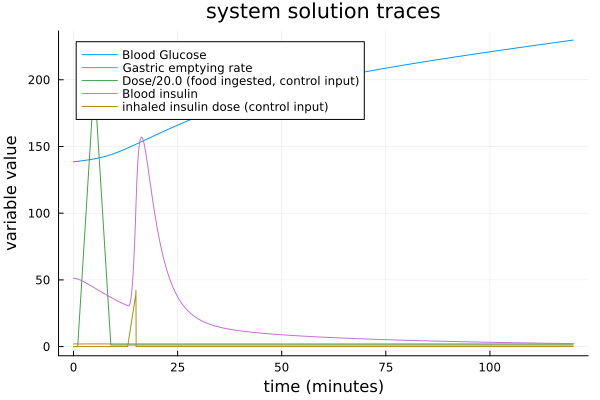

In [20]:
#note: the model is only valid if the values are within human physiological bounds. 
#the following solution example is clearly invalid.


plot(title = "system solution traces", xlabel = "time (minutes)", ylabel = "variable value")
plot!(sol, idxs = (t, G), label = "Blood Glucose") #blue
plot!(sol, idxs = (t, K_EMPT_IMPL(Q_sto, Dose)), label = "Gastric emptying rate") #orange
plot!(sol, idxs = (t, Dose./20), label = "Dose/20.0 (food ingested, control input)") #blue
plot!(sol, idxs = (t, I), label = "Blood insulin")
plot!(sol, idxs = (t, u_ih), label = "inhaled insulin dose (control input)")
# plot!(sol, idxs = (t, Ra_i))
    # which obscures the traces
# savefig("solution_traces.png")

In [21]:
substitute(K_EMPT_IMPL(0.0, 0.0), pmap)

2.008

In [22]:
# rootfinding_problem = NonlinearProblem(prob)
# solve(rootfinding_problem)

In [29]:
# display(equations(complete_model)) #after structural simplification
x_simplified = unknowns(complete_model)
p_simplified = parameters(complete_model)
eq_simplified_rhs = [eq.rhs for eq in equations(complete_model)];
sym_jacobian = Symbolics.jacobian(eq_simplified_rhs, x_simplified)
# display(sym_jacobian) #sparse matrix

85×85 Matrix{Num}:
 ifelse(G_p(t) >= 0.0, -k_1 - k_p2, 0)  …  ifelse(G_p(t) >= 0.0, -X_L(t), 0)
         ifelse(G_t(t) >= 0.0, k_1, 0)                                     0
                                     0                                     0
                                     0                                     0
                                     0                                     0
                                     0  …                                  0
                                     0                                     0
                                     0                                     0
                                     0                                     0
                                     0                                     0
                                     ⋮  ⋱  
                                     0                                     0
                                     0                                     0
             

In [ ]:
display(size(sym_jacobian)) 

(85, 85)

In [25]:
function f_simplified(u, p, t)
    varmap = vcat(
        pmap,
        [(item => u[i]) for (i, item) in enumerate(x_simplified) ] 
    )
    return simplify(Symbolics.substitute(eq_simplified_rhs, varmap))
end

#don't pass parameters, substitution handled internally by f
rootfinding_problem = NonlinearProblem(f_simplified, prob.u0) 
sol_roots = solve(rootfinding_problem)
#(85, 85)
#retcode: Success
# u: 85-element Vector{Float64}:
#  260.49
#  205.57
#    2.56
#    2.61 ... 0.009


retcode: Success
u: 85-element Vector{Float64}:
 260.49
 205.57
   2.56
   2.61
   0.0
   0.0
   0.0
  51.18
  51.18
   0.0
   ⋮
   0.6
   0.6
   0.0
   0.0
   0.0
   0.0
   0.0
   2.7
   0.009

In [26]:
sym_jacobian = Symbolics.jacobian(eq_simplified_rhs, x_simplified)
display(size(sym_jacobian)) #(85, 85)

(85, 85)

In [30]:
Y_intermediate = Symbolics.jacobian(eq_simplified_rhs .- sol_roots.u, p_simplified);
#subtract the eq point, and derivs will = 0 @ x_simplified = 0
#display(size(sym_jacobian)) #(85, 68)

85×68 Matrix{Num}:
 0  …  0
 0     0
 0     0
 0     0
 0     0
 0  …  0
 0     0
 0     0
 0     0
 0     0
 ⋮  ⋱  
 0     0
 0     0
 0     0
 0     0
 0  …  0
 0     0
 0     0
 0     0
 0     0

# Reference implementation of adaptive control with MTK

In [28]:
#on a simple problem, described in chapter 9 of \cite{Applied Nonlinear Control, Slotine, Li}
degree = pi / 180.0

@independent_variables t # use unitless time
D = Differential(t)
@variables begin
    qd1(t)
    qd2(t)
    q_dot1(t) = 0
    q_dot2(t) = 0
    q1(t) = 0
    q2(t) = 0
    q_tilda1(t) = 0
    q_tilda2(t) = 0
    τ1(t) = 0
    τ2(t) = 0
    a_hat1(t) = 0
    a_hat2(t) = 0
    a_hat3(t) = 0
    a_hat4(t) = 0
    s1(t) = 0
    s2(t) = 0
    q_dot_r1(t) = 0
    q_dot_r2(t) = 0
end

@parameters begin
    m1 = 1.0
    l1 = 1.0
    me = 2.0
    de = 30 * degree
    i1 = 0.12
    lc1 = 0.5
    ie = 0.25
    lce = 0.6
end

#implementation detail
Λ = 20.0
Kd = 100.0
qd = [qd1, qd2]

q = [q1, q2]
q_dot = [q_dot1, q_dot2]
q_dot_dot = D.(q_dot)

q_error = [q_tilda1, q_tilda2]

s = [s1, s2]

q_dot_r = [q_dot_r1, q_dot_r2]
q_dot_dot_r = D.(q_dot_r)

a_hat_vector = [a_hat1, a_hat2, a_hat3, a_hat4]

#actual system parameters
a = [
    (i1 + (m1 * (lc1^2.0)) + ie + (me * (lce^2.0)) + (me * (l1^2.0))),
    (ie + (me * (lce^2.0))),
    (me * l1 * lce * cos(de)),
    (me * l1 * lce * sin(de)),
]  

#model structure
y13 = (2 * q_dot_dot_r[1] + q_dot_dot_r[2])*cos(q[2]) - (q_dot[2]*q_dot_r[1] + q_dot[1]*q_dot_r[2] + q_dot[2]*q_dot_r[2])*sin(q[2])
y14 = (2 * q_dot_dot_r[1] + q_dot_dot_r[2])*sin(q[2]) + (q_dot[2]*q_dot_r[1] + q_dot[1]*q_dot_r[2] + q_dot[2]*q_dot_r[2])*cos(q[2])
y23 = q_dot_dot_r[1]*cos(q[2]) + q_dot[2]*q_dot_r[1]*sin(q[2])
y24 = q_dot_dot_r[1]*sin(q[2]) - q_dot[1]*q_dot_r[1]*cos(q[2])

Y = [
    (q_dot_dot_r[1]) (q_dot_dot_r[2]) (y13) (y14);
    (0) (q_dot_dot_r[1] + q_dot_dot_r[2]) (y23) (y24)
]


h(q, a_) = (a_[3] * sin(q[2])) - (a_[4] * cos(q[2]))

H12(q, a_) = a_[2] + (a_[3] * cos(q[2])) + (a_[4] * sin(q[2]))

H_(q, a_) = [
    (a_[1] + (2*a_[3]*cos(q[2])) + (2*a_[4]*sin(q[2]))) (H12(q, a_));
    (H12(q, a_)) (a_[2])
]

h_intermediate(q, a_) = [ #matrix, 2 rows
    (-h(q, a_) * q_dot[2]) (-h(q, a_) * (q_dot[1] + q_dot[2])); 
    (h(q, a_) * q_dot[1]) (0)
]
#adaptation law
a_hat_dot = -1 * diagm([0.03, 0.05, 0.1, 0.3]) * Y' * s 
#control law
# τ = H(q, a_hat)*q_dot_dot_r + (h_intermediate(q, a_hat) * q_dot_r) - Kd*(D.(q_error) + Λ*q)
# τ = simplify((Y*a_hat_vector) - (Kd.*s))

q_eqn_lhs = simplify.((H_(q,a) * q_dot_dot) + (h_intermediate(q, a) * q_dot))
τ_eqns = simplify(H_(q, a_hat_vector)*q_dot_dot_r + (h_intermediate(q, a_hat_vector) * q_dot_r) - (Kd.*s))

@mtkmodel pset4_2 begin
    @variables begin
        qd1(t)
        qd2(t)
        q_dot1(t) = 0
        q_dot2(t) = 0
        q1(t) = 0
        q2(t) = 0
        q_tilda1(t) = 0
        q_tilda2(t) = 0
        τ1(t) = 0
        τ2(t) = 0
        a_hat1(t) = 0
        a_hat2(t) = 0
        a_hat3(t) = 0
        a_hat4(t) = 0
        s1(t) = 0
        s2(t) = 0
        q_dot_r1(t) = 0
        q_dot_r2(t) = 0
    end
    
    @parameters begin #now not using mtk params
        m1 = 1.0
        l1 = 1.0
        me = 2.0
        de = 30 * degree
        i1 = 0.12
        lc1 = 0.5
        ie = 0.25
        lce = 0.6
    end
    
    @equations begin
        qd1 ~ (30*(1-cos(2*pi*t)) * degree)
        qd2 ~ (45*(1-cos(2*pi*t)) * degree)
        q_eqn_lhs[1] ~ τ1
        q_eqn_lhs[2] ~ τ2
        τ1   ~ τ_eqns[1]
        τ2   ~ τ_eqns[2]
        q_tilda1 ~ q1 - qd1
        q_tilda2 ~ q2 - qd2
        s1 ~ D(q_tilda1) + (Λ*q_tilda1)
        s2 ~ D(q_tilda2) + (Λ*q_tilda2)
        q_dot1 ~ D(q1)
        q_dot2 ~ D(q2)
        q_dot_r1 ~ q_dot1 - s1
        q_dot_r2 ~ q_dot2 - s2
        D(a_hat_vector[1]) ~ a_hat_dot[1]#symbolic derivative expressions tied to actual value from adaptation law
        D(a_hat_vector[2]) ~ a_hat_dot[2]
        D(a_hat_vector[3]) ~ a_hat_dot[3]
        D(a_hat_vector[4]) ~ a_hat_dot[4]
    end
end

@named model_2 = pset4_2()
model_2_complete = structural_simplify(model_2, io = ([qd1, qd2], []))
prob_2 = ODEProblem(model_2_complete, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
sol_2 = solve(prob_2, tspan = [0,3]);